# Consideraciones acerca de Threading

Tiempos de procesamiento de datos

    •	CPU L1 Cache: 0.9 ns
    •	RAM: 51 ns
    •	SSD: 0.08 a 0.15 ms = 80.000 a 150.000 ns 
    •	HDD 7.2k: 4 ms = 4.000.000 ns
    •	Red: 400 ms = 400.000.000 ns

Unidad equivalente 0.9 nanosegunos computacionales = 1 segundo humano

    •	CPU: 1 seg
    •	RAM: 1 minuto
    •	SSD: 1 a 2 dias
    •	HDD: 1mes y medio
    •	Red: 14 años

# Importamos las librerías

In [1]:
import pandas as pd
import requests
import numpy as np
import threading
import tqdm, sys
import pickle
import datetime as dt

# Config de display
pd.options.display.max_columns=6

# Claves de APIs
from _keys import *

## Tema Claves

Registrarse en (Todo gratarola)

* IEX: https://iexcloud.io/
* TDA-Ameritrade: https://developer.tdameritrade.com/apis 
    * Ir a MyApps >> Nueva App >> En callBack url poner cualquier url tipo http://google.com >> Listo, Ver consumer Key
* FMP: https://fmpcloud.io/
* Alpaca: https://alpaca.markets/
    * En Alpaca te dan un par: ApiKey y ApiSecret


Yo las guardé en un archivo _keys.py  que obviamente en el repo esta sin las claves,y lo tienen que actualizar


# Tickers del SP500

## Scrapping Basico

In [2]:
sp500_wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_wiki = sp500_wiki.loc[~sp500_wiki.Symbol.isin(['BRK.B' ,'BF.B'])]
sp500_wiki

,Symbol,Security,SEC filings,...,Date first added,CIK,Founded
0,MMM,3M Company,reports,...,1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,...,1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,...,2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,...,2018-05-31,815094,1981
4,ACN,Accenture plc,reports,...,2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,...,1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,...,2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,...,2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,...,2001-06-22,109380,1873


In [3]:
sp500_tickers = sp500_wiki.Symbol.tolist()
sp500_tickers[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

## Guardamos la data

In [4]:
with open('data/inicial/wiki_sp500.dat', 'wb') as file:
    pickle.dump(sp500_wiki, file)

In [5]:
with open('data/inicial/wiki_sp500.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Symbol,Security,SEC filings,...,Date first added,CIK,Founded
0,MMM,3M Company,reports,...,1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,...,1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,...,2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,...,2018-05-31,815094,1981
4,ACN,Accenture plc,reports,...,2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,...,1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,...,2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,...,2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,...,2001-06-22,109380,1873


# Opciones desde TDA

In [6]:
c_key = TDA_KEY

In [7]:
def options(symbol):
    params = {'apikey' : c_key, 'symbol':symbol}
    endpoint = 'https://api.tdameritrade.com/v1/marketdata/chains'
    r = requests.get(url=endpoint ,params=params)
    return r.json()

In [8]:
ticker = 'GGAL'
chain = options(ticker)
chain

{'symbol': 'GGAL',
 'status': 'SUCCESS',
 'underlying': None,
 'strategy': 'SINGLE',
 'interval': 0.0,
 'isDelayed': True,
 'isIndex': False,
 'interestRate': 0.1,
 'underlyingPrice': 8.094999999999999,
 'volatility': 29.0,
 'daysToExpiration': 0.0,
 'numberOfContracts': 104,
 'putExpDateMap': {'2020-11-20:5': {'2.5': [{'putCall': 'PUT',
     'symbol': 'GGAL_112020P2.5',
     'description': 'GGAL Nov 20 2020 2.5 Put',
     'exchangeName': 'OPR',
     'bid': 0.0,
     'ask': 0.05,
     'last': 0.0,
     'mark': 0.03,
     'bidSize': 0,
     'askSize': 141,
     'bidAskSize': '0X141',
     'lastSize': 0,
     'highPrice': 0.0,
     'lowPrice': 0.0,
     'openPrice': 0.0,
     'closePrice': 0.0,
     'totalVolume': 0,
     'tradeDate': None,
     'tradeTimeInLong': 0,
     'quoteTimeInLong': 1605301080935,
     'netChange': 0.0,
     'volatility': 411.329,
     'delta': -0.012,
     'gamma': 0.006,
     'theta': -0.01,
     'vega': 0.0,
     'rho': 0.0,
     'openInterest': 0,
     'timeV

## Metemos el OptionChain en un DataFrame

In [9]:
ticker = 'AAPL'
chain = options(ticker)

v_calls = list(chain['callExpDateMap'].values())
v_calls_fechas = list(chain['callExpDateMap'].keys())
v_puts = list(chain['putExpDateMap'].values())
v_puts_fechas = list(chain['putExpDateMap'].keys())
calls = []
for i in range(len(v_calls)):
    v = list(v_calls[i].values())    
    for j in range(len(v)):
        calls.append(v[j][0])

puts = []
for i in range(len(v_puts)):
    v = list(v_puts[i].values())    
    for j in range(len(v)):
        puts.append(v[j][0])
        
contracts = pd.concat([pd.DataFrame(calls),pd.DataFrame(puts)])

tabla = contracts.loc[contracts.daysToExpiration>0]
tabla = tabla.loc[:,['symbol','strikePrice','daysToExpiration','putCall','bid','ask',
                     'last','volatility','openInterest','theoreticalOptionValue',
                     'delta', 'gamma', 'theta', 'vega', 'rho', 'inTheMoney']]

tabla.columns = ['symbol_opc','Strike','TTM','Type','Bid','Ask','Last','IV','OpenInt','Theor',
                 'delta', 'gamma', 'theta', 'vega', 'rho','ITM']

tabla['symbol'] = ticker
tabla

,symbol_opc,Strike,TTM,...,rho,ITM,symbol
0,AAPL_112020C20,20.0,5,...,0,True,AAPL
1,AAPL_112020C22.5,22.5,5,...,0,True,AAPL
2,AAPL_112020C25,25.0,5,...,0,True,AAPL
3,AAPL_112020C30,30.0,5,...,0,True,AAPL
4,AAPL_112020C35,35.0,5,...,0.001,True,AAPL
...,...,...,...,...,...,...,...
1150,AAPL_012023P190,190.0,796,...,-3.721,True,AAPL
1151,AAPL_012023P195,195.0,796,...,-3.864,True,AAPL
1152,AAPL_012023P200,200.0,796,...,-4.007,True,AAPL
1153,AAPL_012023P210,210.0,796,...,-4.283,True,AAPL


## Encapsulamos el DF en una función

In [10]:
def optionsDF(chain):
    try:
        v_calls = list(chain['callExpDateMap'].values())
        v_calls_fechas = list(chain['callExpDateMap'].keys())
        v_puts = list(chain['putExpDateMap'].values())
        v_puts_fechas = list(chain['putExpDateMap'].keys())
        calls = []
        for i in range(len(v_calls)):
            v = list(v_calls[i].values())    
            for j in range(len(v)):
                calls.append(v[j][0])

        puts = []
        for i in range(len(v_puts)):
            v = list(v_puts[i].values())    
            for j in range(len(v)):
                puts.append(v[j][0])

        contracts = pd.concat([pd.DataFrame(calls),pd.DataFrame(puts)])
        tabla = contracts.loc[contracts.daysToExpiration>0]
        tabla = tabla.loc[:,['symbol','strikePrice','daysToExpiration','putCall','bid','ask',
                             'last','volatility','openInterest','theoreticalOptionValue',
                             'delta', 'gamma', 'theta', 'vega', 'rho', 'inTheMoney']]

        tabla.columns = ['symbol_opc','Strike','TTM','Type','Bid','Ask','Last','IV','OpenInt','Theor',
                         'delta', 'gamma', 'theta', 'vega', 'rho','ITM']

        tabla['symbol'] = chain['symbol']
    except:
        tabla = pd.DataFrame()
        
    return tabla

In [11]:
ticker = 'FB'
df = optionsDF(options(ticker))
df

,symbol_opc,Strike,TTM,...,rho,ITM,symbol
0,FB_112020C75,75.0,5,...,NaN,True,FB
1,FB_112020C80,80.0,5,...,NaN,True,FB
2,FB_112020C85,85.0,5,...,NaN,True,FB
3,FB_112020C90,90.0,5,...,NaN,True,FB
4,FB_112020C95,95.0,5,...,0.016,True,FB
...,...,...,...,...,...,...,...
1187,FB_012023P480,480.0,796,...,-4.431,True,FB
1188,FB_012023P500,500.0,796,...,-4.161,True,FB
1189,FB_012023P520,520.0,796,...,-4.023,True,FB
1190,FB_012023P540,540.0,796,...,-3.901,True,FB


## Graficamos algo

In [12]:
from scipy import interpolate
import matplotlib.pyplot as plt

%matplotlib inline

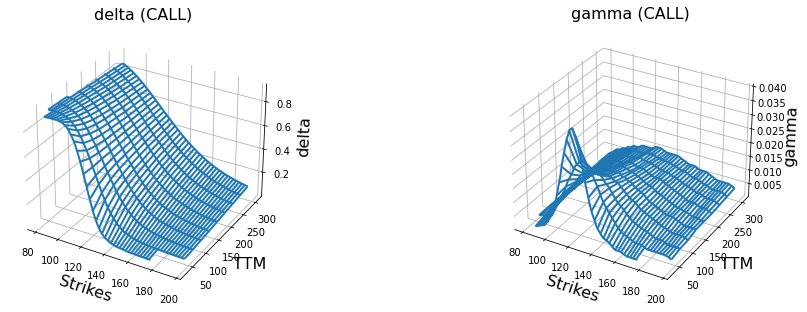

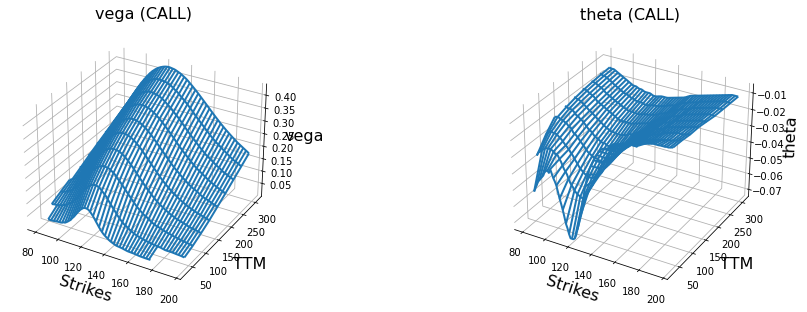

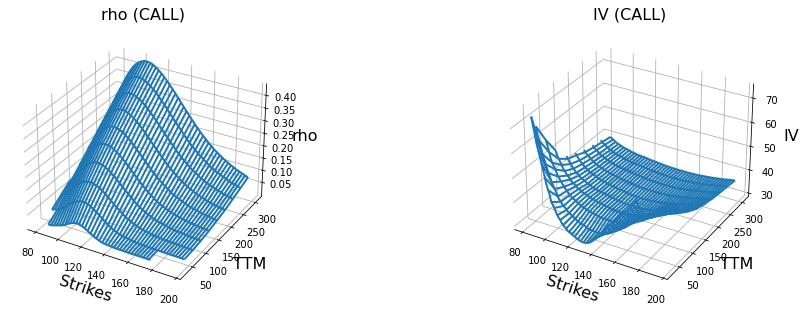

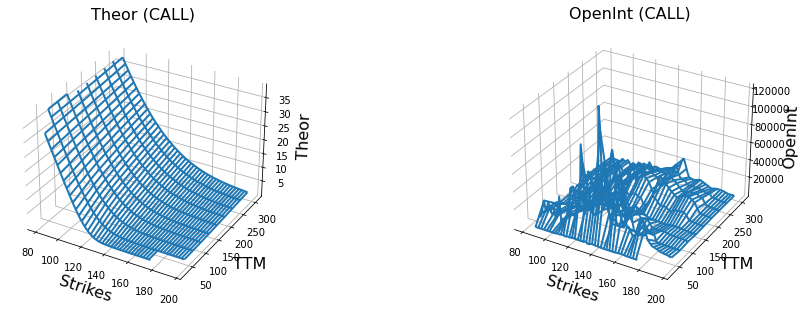

In [13]:

def prepararMalla(columna, df, leg=None):
    if leg:
        df = df.loc[df['Type']==leg].copy()
        
    df_ok = df.loc[:,['Strike','TTM',columna]]
    df_ok = df_ok.replace('NaN',np.nan).dropna()    
    x_q = len(df_ok['Strike'].unique())
    y_q = len(df_ok['TTM'].unique())
    x1 = np.linspace(df_ok['Strike'].min(), df_ok['Strike'].max(), x_q)
    y1 = np.linspace(df_ok['TTM'].min(), df_ok['TTM'].max(), y_q)
    X, Y = np.meshgrid(x1, y1)
    Z = interpolate.griddata((df_ok['Strike'], df_ok['TTM']), df_ok[columna], (X, Y))
    return X,Y,Z, df_ok

def grafCols(cols, leg=None, size=(16,5)):
    fig = plt.figure(figsize=size)
    ax = [fig.add_subplot(1, len(cols), i+1, projection='3d') for i in range(len(cols))]
    for i in range(len(cols)):
        col = cols[i]
        df_greeks = df_ok.copy()
        X,Y,Z,df = prepararMalla(col, df_greeks, leg=leg)    
        ax[i].plot_wireframe(X, Y, Z, color='tab:blue', lw=2)     
        ax[i].set_title(f'{col} ({leg})', fontsize=16, color='k')
        ax[i].set_xlabel('Strikes', fontsize=16, color='k')
        ax[i].set_ylabel('TTM', fontsize=16, color='k')
        ax[i].set_zlabel(col, fontsize=16, color='k')
        ax[i].w_xaxis.set_pane_color((0,0,0,0))
        ax[i].w_yaxis.set_pane_color((0,0,0,0))
        ax[i].w_zaxis.set_pane_color((0,0,0,0))

ticker = 'AAPL'
k_min = 80
k_max=200
ttm_min=25
ttm_max=365

data = optionsDF(options(ticker))
df_ok = data.loc[(data['Strike'] > k_min) & (data['Strike'] < k_max)]
df_ok = df_ok.loc[(df_ok['TTM'] > ttm_min) & (df_ok['TTM'] < ttm_max)]   


grafCols(['delta','gamma'], 'CALL')
grafCols(['vega','theta'], 'CALL')
grafCols(['rho','IV'], 'CALL')
grafCols(['Theor','OpenInt'], 'CALL')
plt.show()

## Gráfica 3D interactiva básica

<IPython.core.display.Javascript object>


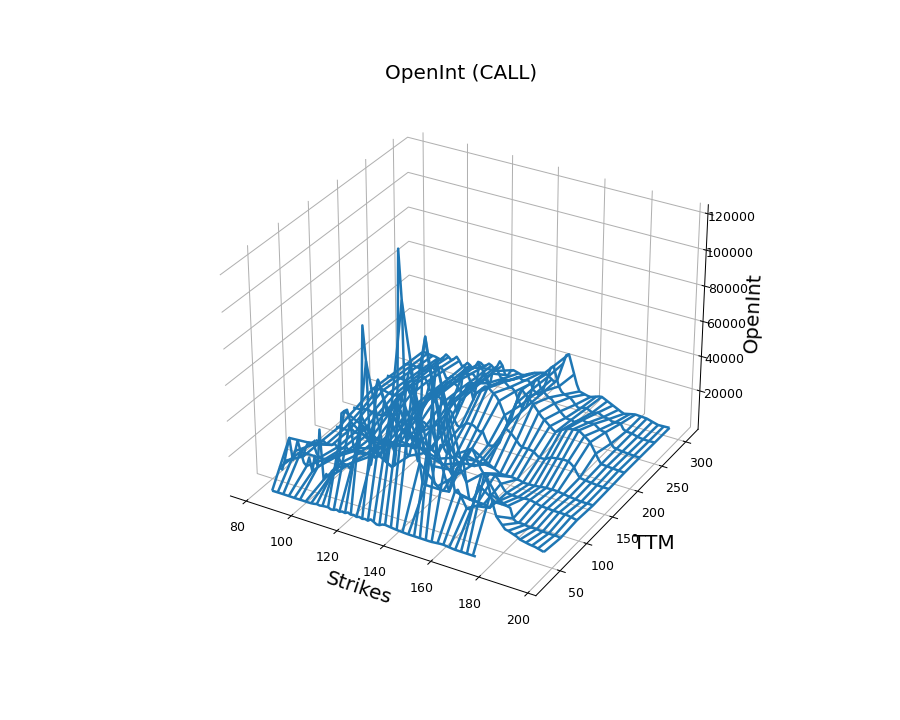

In [14]:
%matplotlib notebook

ticker = 'AAPL'
k_min = 80
k_max = 200
ttm_min = 25
ttm_max = 365

data = optionsDF(options(ticker))
df_ok = data.loc[(data['Strike'] > k_min) & (data['Strike'] < k_max)]
df_ok = df_ok.loc[(df_ok['TTM'] > ttm_min) & (df_ok['TTM'] < ttm_max)]   

grafCols(['OpenInt'], 'CALL', size=(10,8))

## Bajamos Opciones del SP500

In [15]:
with open('data/inicial/wiki_sp500.dat', 'rb') as file:
    loaded = pickle.load(file)

In [16]:
tickers= loaded.Symbol.to_list()
tickers[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

In [17]:
n_threads = 2
subs = np.array_split(tickers, n_threads)

In [18]:
%%time

dfs = []
def worker(tickers):
    for ticker in tickers:
        print(ticker, end=' ')
        df = optionsDF(options(ticker))
        dfs.append(df)
    return df

threads = []
for i in range(n_threads):
    t = threading.Thread(target=worker, args=(subs[i],))
    threads.append(t)
    t.start()
    
for t in threads:
    t.join()
    
sp500_opciones = pd.concat(dfs)
sp500_opciones

MMM INTU ABT ISRG ABBV IVZ ABMD IPGP IQV ACN IRM ATVI JKHY J ADBE JBHT AMD SJM JNJ AAP JCI AES AFL JPM JNPR A KSU APD K AKAM KEY KEYS ALK ALB KMB ARE KIM ALXN KMI ALGN KLAC ALLE KHC LNT ALL KR GOOGL LB GOOG LHX LH MO LRCX AMZN LW LVS AMCR AEE LEG AAL LDOS AEP LEN AXP LLY AIG LNC AMT LIN AWK LYV AMP LKQ ABC LMT AME L AMGN LOW APH LUMN ADI LYB ANSS MTB ANTM MRO AON MPC AOS MKTX APA MAR AIV AAPL MMC MLM AMAT MAS APTV MA ADM MKC ANET MXIM AJG MCD AIZ T MCK ATO MDT ADSK MRK ADP MET AZO MTD AVB MGM AVY MCHP BKR BLL MU BAC MSFT BK MAA BAX MHK BDX TAP BBY MDLZ BIO MNST BIIB MCO BLK MS MOS BA MSI BKNG MSCI MYL BWA BXP NDAQ BSX NOV BMY NTAP NFLX AVGO NWL BR NEM CHRW NWSA COG NWS NEE CDNS NLSN CPB NKE COF NI CAH NSC KMX NTRS CCL NOC CARR NLOK CTLT NCLH CAT NRG NUE CBOE NVDA CBRE CDW NVR CE ORLY CNC OXY ODFL CNP OMC CERN OKE CF ORCL SCHW OTIS CHTR PCAR PKG CVX PH PAYX CMG PAYC CB PYPL CHD PNR CI PBCT CINF PEP CTAS PKI CSCO PRGO C PFE PM CFG CTXS PSX PNW CLX PXD PNC CME POOL CMS KO PPG CTSH CL PPL 

,symbol_opc,Strike,TTM,...,rho,ITM,symbol
0,MMM_112020C65,65.0,5,...,0.002,True,MMM
1,MMM_112020C70,70.0,5,...,0.002,True,MMM
2,MMM_112020C75,75.0,5,...,0.002,True,MMM
3,MMM_112020C80,80.0,5,...,0.002,True,MMM
4,MMM_112020C85,85.0,5,...,0.002,True,MMM
...,...,...,...,...,...,...,...
192,IFF_012023P165,165.0,796,...,-3.177,True,IFF
193,IFF_012023P170,170.0,796,...,-3.326,True,IFF
194,IFF_012023P175,175.0,796,...,-3.448,True,IFF
195,IFF_012023P180,180.0,796,...,-3.606,True,IFF


## Guardamos la data

In [19]:
with open('data/inicial/tda_opc_sp500.dat', 'wb') as file:
    pickle.dump(sp500_opciones, file)

In [20]:
with open('./data/inicial/tda_opc_sp500.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,symbol_opc,Strike,TTM,...,rho,ITM,symbol
0,MMM_112020C65,65.0,5,...,0.002,True,MMM
1,MMM_112020C70,70.0,5,...,0.002,True,MMM
2,MMM_112020C75,75.0,5,...,0.002,True,MMM
3,MMM_112020C80,80.0,5,...,0.002,True,MMM
4,MMM_112020C85,85.0,5,...,0.002,True,MMM
...,...,...,...,...,...,...,...
192,IFF_012023P165,165.0,796,...,-3.177,True,IFF
193,IFF_012023P170,170.0,796,...,-3.326,True,IFF
194,IFF_012023P175,175.0,796,...,-3.448,True,IFF
195,IFF_012023P180,180.0,796,...,-3.606,True,IFF


# IEX

In [21]:
iex_token = IEX_TOKEN

In [22]:
def iex_intraday(symbol):
    url = f'https://cloud.iexapis.com/stable/stock/{symbol}/intraday-prices'
    params = {'chartIEXOnly':True, 'token':iex_token }
    js = requests.get(url, params=params).json()
    df = pd.DataFrame(js)
    df.date = pd.to_datetime(df.date)
    df['symbol'] = symbol
    df['pctChange'] = df.average.pct_change()*100
    return df.dropna().round(3)

## Descarga con hilos

In [23]:
n_threads = 30
subs = np.array_split(sp500_tickers, n_threads)

In [24]:
%%time

dfs = []
def worker(tickers):
    for ticker in tickers:
        print(ticker, end=' ')
        df = iex_intraday(ticker)
        dfs.append(df)
    return df

    
threads = []
for i in range(n_threads):
    t = threading.Thread(target=worker, args=(subs[i],))
    threads.append(t)
    t.start()
    
for t in threads:
    t.join()
    
result = pd.concat(dfs)
result

MMM ALXN AMP AJG BIIB CCL CHD CXO DE DTE EQR FIS GPS HCA HII IPGP KMI LKQ MCD MOS NTRS PH PPL O STX SIVB TMO UNP V WU ABT BLK ABCCI DUK ESS  IEXKLAC COP  CARRALGNVNT   NOC REGSEE GRMN  FITB WRKAIZ LMT DAL  PFGIQV MSI  MCKUAL PAYX  TIFPEAK  SYF ABBV BA AME EL DRE ALLE IDXX CTLT CINF SREKHC IRM  REGNVNO  IT HSIC MSCI FE TNLOK SNPS  TJX L PGMDT PAYC  UNH WY ED XRAY ABMD BKNG AMGN DD ETSY LNT INFO CAT KR CTAS JKHY VMCRF  GD LOWSTZHSY   ATO PGR WHR FRC NOWSYY  DVN NCLH MRK PYPL TSCO MYL UPS ACN APHDXC  BWA EVRG ITW CBOE ALL J LB CSCO RSG HES GE COO WRB LUMN DXCM NRG PLD ADSKTT  MET PNR NDAQWMB  SHWURI ATVI  TMUS FISV BXP ADI EMN ES GOOGL CBRE ILMN JBHT LHX C RMD HPE CPRT GIS FANG WAB TDG NUE MTDLYB  SPGFLT  BSXADP  ADBEPRU  ETNPBCT WLTW  TROW NOVANSS UHS  CDW RE GOOG INCY SJM CFG LH RHI HLT GLW GM WMT DLR TRV NVDA MGM SWKS AZO FLIR ANTM AMDBMY NTAP  MTBUNM TTWO  WYNN MOPEP EXC EBAY  IR PEG JNJCE  LRCX CTXS ROK HFC CTVA GPC DFS WBA TFC NVR MCHP SLG FLS AVB AON NFLX MRO AVGO AAP EXPE CLXPSA X

,date,minute,label,...,numberOfTrades,symbol,pctChange
1,2020-11-13,09:31,09:31 AM,...,5,MMM,0.113
2,2020-11-13,09:32,09:32 AM,...,3,MMM,-0.018
3,2020-11-13,09:33,09:33 AM,...,4,MMM,0.066
4,2020-11-13,09:34,09:34 AM,...,4,MMM,0.036
5,2020-11-13,09:35,09:35 AM,...,12,MMM,0.125
...,...,...,...,...,...,...,...
385,2020-11-13,15:55,3:55 PM,...,39,RTX,-0.091
386,2020-11-13,15:56,3:56 PM,...,29,RTX,0.041
387,2020-11-13,15:57,3:57 PM,...,19,RTX,0.057
388,2020-11-13,15:58,3:58 PM,...,40,RTX,0.083


## Guardamos la Data

In [25]:
with open('data/inicial/iex_intra.dat', 'wb') as file:
    pickle.dump(result, file)

In [26]:
with open('data/inicial/iex_intra.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,date,minute,label,...,numberOfTrades,symbol,pctChange
1,2020-11-13,09:31,09:31 AM,...,5,MMM,0.113
2,2020-11-13,09:32,09:32 AM,...,3,MMM,-0.018
3,2020-11-13,09:33,09:33 AM,...,4,MMM,0.066
4,2020-11-13,09:34,09:34 AM,...,4,MMM,0.036
5,2020-11-13,09:35,09:35 AM,...,12,MMM,0.125
...,...,...,...,...,...,...,...
385,2020-11-13,15:55,3:55 PM,...,39,RTX,-0.091
386,2020-11-13,15:56,3:56 PM,...,29,RTX,0.041
387,2020-11-13,15:57,3:57 PM,...,19,RTX,0.057
388,2020-11-13,15:58,3:58 PM,...,40,RTX,0.083


# Finviz

## Traemos los datos de la WEB

In [27]:
def scrapear(pags=range(1,3)):
    agents = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) '
    agents += 'Chrome/50.0.2661.75 Safari/537.36'
    header = {"User-Agent": agents, "X-Requested-With": "XMLHttpRequest"}
    vista_simple = '111'
    vista_full = '152&c='+','.join([str(s) for s in list(range(0,71))])

    df = pd.DataFrame()

    paginas = 1000
    with tqdm.tqdm(total=len(pags), file=sys.stdout) as pbar:
        for pagina in pags:
            pbar.update()

            r = str((pagina)*20 + 1)
            url = f'https://finviz.com/screener.ashx?v={vista_full}&r={r}'
            r = requests.get(url, headers=header)
            tablas = pd.read_html(r.text)

            for tabla in tablas:
                valor = tabla[0].values[0]
                if valor == 'No.':
                    data = tabla

                try:
                    if valor.find('Total: ') == 0:
                        paginas = int(valor[7:valor.find('#')-1])//20 +1
                except:
                    pass

            if pagina == paginas:
                break

            data.columns=data.loc[0]
            data = data.drop(0).drop('No.', axis=1).set_index('Ticker')
            df = pd.concat([df,data])

    return df

In [28]:
finviz = scrapear(pags=range(390))

 98%|█████████▊| 383/390 [03:44<00:04,  1.70it/s]


## Guardamos la Data Inicial

In [29]:
with open('data/inicial/finviz.dat', 'wb') as file:
    pickle.dump(finviz, file)

In [30]:
with open('data/inicial/finviz.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Company,Sector,Industry,...,Earnings,Target Price,IPO Date
Ticker,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,...,Nov 23/a,104.71,11/18/1999
AA,Alcoa Corporation,Basic Materials,Aluminum,...,Oct 14/a,14.65,10/18/2016
AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,...,-,-,8/15/2018
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,...,Nov 12/a,-,1/29/2008
AACQ,Artius Acquisition Inc.,Financial,Shell Companies,...,-,-,9/4/2020
...,...,...,...,...,...,...,...
ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,...,Sep 02/a,13.58,4/12/2018
ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,...,Oct 28/a,-,4/15/2009
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,...,Nov 03/b,24.88,4/28/2017


## Arreglamos datos

### Eliminamos símbolos no numéricos

In [31]:
finviz.replace('-',np.nan, inplace=True)
finviz.replace({'%': ''}, regex=True, inplace=True)

### Arreglamos los numericos hibridos

In [32]:
def aNumerico(df, columnas):

    for columna in columnas:
        count_T, count_B, count_M, count_K = 0,0,0,0
        
        for idx, row in finviz.iterrows():
            try:
                trillones = (row[columna]).find('T') 
                billones = (row[columna]).find('B') 
                millones = (row[columna]).find('M')
                miles = (row[columna]).find('K')

                if  trillones > 0:
                    count_T += 1
                    row[columna] = int(round(float(row[columna][:trillones]),2) * 10**12)
                elif  billones > 0:
                    count_B += 1
                    row[columna] = int(round(float(row[columna][:billones]),2) * 10**9)
                elif  millones > 0:
                    count_M += 1
                    row[columna] = int(round(float(row[columna][:millones]),2) * 10**6)
                elif  miles > 0:
                    count_K += 1
                    row[columna] = int(round(float(row[columna][:miles]),2) * 10**3)
                else:
                    row[columna] = int(row[columna])
                    
            except:
                pass
            
        print(f'Columna: {columna}, T->{count_T}, B->{count_B}, M->{count_M}, K->{count_K}')

In [33]:
columnas = ['Market Cap', 'Avg Volume','Outstanding','Float',]

aNumerico(finviz, columnas)

Columna: Market Cap, T->0, B->2434, M->2975, K->0
Columna: Avg Volume, T->0, B->0, M->1699, K->5923
Columna: Outstanding, T->0, B->189, M->5222, K->0
Columna: Float, T->0, B->152, M->4690, K->0


### Pasamos a Flotante lo que sea flotante

In [34]:
finviz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7622 entries, A to ZYXI
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company        7622 non-null   object
 1   Sector         7622 non-null   object
 2   Industry       7622 non-null   object
 3   Country        7622 non-null   object
 4   Market Cap     5409 non-null   object
 5   P/E            2561 non-null   object
 6   Fwd P/E        2898 non-null   object
 7   PEG            1670 non-null   object
 8   P/S            4798 non-null   object
 9   P/B            4768 non-null   object
 10  P/C            4362 non-null   object
 11  P/FCF          2509 non-null   object
 12  Dividend       4187 non-null   object
 13  Payout Ratio   2238 non-null   object
 14  EPS            5132 non-null   object
 15  EPS this Y     4684 non-null   object
 16  EPS next Y     4006 non-null   object
 17  EPS past 5Y    3948 non-null   object
 18  EPS next 5Y    3030 non-null   ob

In [35]:
def aFlotante(df, columnas):
    for columna in columnas:
        try:
            df[columna] = df[columna].astype(float)
        except:
            try:
                df[columna] = pd.to_numeric(df[columna])
            except:
                print (f'No se pudo trnasformar la columna {columna}')

In [36]:
columnas_no_float = ['Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Market Cap',
                     'Outstanding','Float','Avg Volume','Volume', 'Earnings', 'IPO Date']

columnas_float = [col for col in list(finviz.columns) if col not in columnas_no_float]
aFlotante(finviz,columnas_float)

### Pasamos a Entero lo que es entero

In [37]:
def aEntero(df, columnas):
    for columna in columnas:
        df[columna] = pd.to_numeric(df[columna])

In [38]:
columnas_int = ['Market Cap', 'Outstanding','Float','Avg Volume','Volume']
aEntero(finviz, columnas_int)

### Pasamos a Fecha lo que se pueda pasar a fecha

In [39]:
finviz['IPO Date'] = pd.to_datetime(finviz['IPO Date'], format='%m/%d/%Y')

### Arreglamos nombres de columnas

In [40]:
columnas_nombres = [c.replace(' ','_') for c in list(finviz.columns)]
finviz.columns = columnas_nombres

In [41]:
columnas_nombres = [c.replace('/','_') for c in list(finviz.columns)]
finviz.columns = columnas_nombres

In [42]:
finviz.index.name = 'Symbol'

In [43]:
finviz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7622 entries, A to ZYXI
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Company        7622 non-null   object        
 1   Sector         7622 non-null   object        
 2   Industry       7622 non-null   object        
 3   Country        7622 non-null   object        
 4   Market_Cap     5409 non-null   float64       
 5   P_E            2561 non-null   float64       
 6   Fwd_P_E        2898 non-null   float64       
 7   PEG            1670 non-null   float64       
 8   P_S            4798 non-null   float64       
 9   P_B            4768 non-null   float64       
 10  P_C            4362 non-null   float64       
 11  P_FCF          2509 non-null   float64       
 12  Dividend       4187 non-null   float64       
 13  Payout_Ratio   2238 non-null   float64       
 14  EPS            5132 non-null   float64       
 15  EPS_this_Y     4684 non-nu

In [44]:
finviz

,Company,Sector,Industry,...,Earnings,Target_Price,IPO_Date
Symbol,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,...,Nov 23/a,104.71,1999-11-18
AA,Alcoa Corporation,Basic Materials,Aluminum,...,Oct 14/a,14.65,2016-10-18
AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,...,NaN,NaN,2018-08-15
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,...,Nov 12/a,NaN,2008-01-29
AACQ,Artius Acquisition Inc.,Financial,Shell Companies,...,NaN,NaN,2020-09-04
...,...,...,...,...,...,...,...
ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,...,Sep 02/a,13.58,2018-04-12
ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,...,Oct 28/a,NaN,2009-04-15
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,...,Nov 03/b,24.88,2017-04-28


## Guardamos la Data Final

In [45]:
with open('data/final/finviz.dat', 'wb') as file:
    pickle.dump(finviz, file)

In [46]:
with open('data/final/finviz.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Company,Sector,Industry,...,Earnings,Target_Price,IPO_Date
Symbol,,,,,,,
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,...,Nov 23/a,104.71,1999-11-18
AA,Alcoa Corporation,Basic Materials,Aluminum,...,Oct 14/a,14.65,2016-10-18
AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,...,NaN,NaN,2018-08-15
AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,...,Nov 12/a,NaN,2008-01-29
AACQ,Artius Acquisition Inc.,Financial,Shell Companies,...,NaN,NaN,2020-09-04
...,...,...,...,...,...,...,...
ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,...,Sep 02/a,13.58,2018-04-12
ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,...,Oct 28/a,NaN,2009-04-15
ZYME,Zymeworks Inc.,Healthcare,Biotechnology,...,Nov 03/b,24.88,2017-04-28


# FMP

In [47]:
def getPanel(exchange):
    url = 'https://fmpcloud.io/api/v3/quotes/'+exchange
    p = {'apikey': FMP_KEY}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    df.set_index('symbol', inplace=True)
    return df

In [48]:
panel_etf = getPanel('nasdaq')
panel_etf.columns

Index(['name', 'price', 'changesPercentage', 'change', 'dayLow', 'dayHigh',
       'yearHigh', 'yearLow', 'marketCap', 'priceAvg50', 'priceAvg200',
       'volume', 'avgVolume', 'exchange', 'open', 'previousClose', 'eps', 'pe',
       'earningsAnnouncement', 'sharesOutstanding', 'timestamp'],
      dtype='object')

In [49]:
panel_etf

,name,price,changesPercentage,...,earningsAnnouncement,sharesOutstanding,timestamp
symbol,,,,,,,
MMDM,Modern Media Acquisition Corp.,1.320,0.76,...,2020-07-16T14:59:00.000+0000,13650800.0,1605449217
TWNK,"Hostess Brands, Inc.",13.530,-0.22,...,2020-11-05T16:05:02.000+0000,130779993.0,1605449217
OTEL,Otelco Inc.,11.450,0.09,...,2020-11-03T21:00:00.000+0000,3421790.0,1605449217
HTLD,"Heartland Express, Inc.",18.940,1.09,...,2020-10-16T09:00:10.000+0000,80798500.0,1605449217
LGIH,"LGI Homes, Inc.",111.920,1.46,...,2020-11-03T07:00:00.000+0000,25100400.0,1605449217
...,...,...,...,...,...,...,...
TBKCP,"Triumph Bancorp, Inc.",26.310,0.30,...,2020-10-20T08:00:00.000+0000,NaN,1605449217
PSTVZ,Plus Therapeutics Inc WT,0.007,-10.26,...,None,NaN,1605449217
NUROW,"NeuroMetrix, Inc.",0.142,0.00,...,2020-04-23T16:30:00.000+0000,NaN,1605449217


## Otros Paneles

In [50]:
paneles = ['etf','commodity','euronext','nyse','amex','nasdaq','tsx','index','mutual_fund']

## Bajamos todos

In [51]:
paneles = ['etf','commodity','euronext','nyse','amex','nasdaq','tsx','index','mutual_fund']

data_fmp = pd.DataFrame()
for panel in paneles:
    print(panel, end=', ')
    df = getPanel(panel)
    df['panel'] = panel
    data_fmp = pd.concat([data_fmp, df])

etf, commodity, euronext, nyse, amex, nasdaq, tsx, index, mutual_fund, 

In [52]:
data_fmp.groupby('panel').size()

panel
amex            284
commodity        29
etf             488
euronext       1254
index            62
mutual_fund    2518
nasdaq         4245
nyse           4574
tsx            1455
dtype: int64

In [53]:
data_fmp

,name,price,changesPercentage,...,sharesOutstanding,timestamp,panel
symbol,,,,,,,
QMOM,Alpha Architect U.S. Quantitative Momentum ETF,43.8700,0.77,...,NaN,1605449219,etf
MFMS,MFAM Small-Cap Growth ETF,36.3350,1.02,...,NaN,1605449219,etf
VMOT,Alpha Architect Value Momentum Trend ETF,23.6880,0.99,...,NaN,1605449219,etf
VSGX,Vanguard ESG International Stock ETF,55.7100,1.29,...,NaN,1605449219,etf
AGT,iShares MSCI Argentina and Global Exposure ETF,22.6516,1.86,...,NaN,1605449219,etf
...,...,...,...,...,...,...,...
NCTWX,Nicholas II Fund Class I,30.9600,1.38,...,NaN,1605449229,mutual_fund
FHCCX,Fidelity Advisor Health Care Fund Class C,52.0700,0.35,...,NaN,1605449229,mutual_fund
FSIMX,Salient Select Income Advisor,23.5700,0.13,...,NaN,1605449229,mutual_fund


## Guardamos la Data Inicial

In [54]:
with open('data/inicial/fmp.dat', 'wb') as file:
    pickle.dump(data_fmp, file)

In [55]:
with open('data/inicial/fmp.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,name,price,changesPercentage,...,sharesOutstanding,timestamp,panel
symbol,,,,,,,
QMOM,Alpha Architect U.S. Quantitative Momentum ETF,43.8700,0.77,...,NaN,1605449219,etf
MFMS,MFAM Small-Cap Growth ETF,36.3350,1.02,...,NaN,1605449219,etf
VMOT,Alpha Architect Value Momentum Trend ETF,23.6880,0.99,...,NaN,1605449219,etf
VSGX,Vanguard ESG International Stock ETF,55.7100,1.29,...,NaN,1605449219,etf
AGT,iShares MSCI Argentina and Global Exposure ETF,22.6516,1.86,...,NaN,1605449219,etf
...,...,...,...,...,...,...,...
NCTWX,Nicholas II Fund Class I,30.9600,1.38,...,NaN,1605449229,mutual_fund
FHCCX,Fidelity Advisor Health Care Fund Class C,52.0700,0.35,...,NaN,1605449229,mutual_fund
FSIMX,Salient Select Income Advisor,23.5700,0.13,...,NaN,1605449229,mutual_fund


## Verificamos tipos de datos

In [56]:
data_fmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14909 entries, QMOM to GEQZX
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14818 non-null  object 
 1   price                 14398 non-null  float64
 2   changesPercentage     14908 non-null  float64
 3   change                14384 non-null  float64
 4   dayLow                11907 non-null  float64
 5   dayHigh               11907 non-null  float64
 6   yearHigh              14383 non-null  float64
 7   yearLow               14383 non-null  float64
 8   marketCap             8571 non-null   object 
 9   priceAvg50            14002 non-null  float64
 10  priceAvg200           14004 non-null  float64
 11  volume                11875 non-null  float64
 12  avgVolume             14001 non-null  float64
 13  exchange              14909 non-null  object 
 14  open                  11846 non-null  float64
 15  previousClose        

## Transformamos a numérico

In [57]:
aFlotante(data_fmp, ['marketCap','eps','pe','earningsAnnouncement','sharesOutstanding'])

No se pudo trnasformar la columna earningsAnnouncement


## Transformamos fechas

In [58]:
data_fmp['timestamp'] = pd.to_datetime(data_fmp['timestamp'], unit='s')

In [59]:
data_fmp

,name,price,changesPercentage,...,sharesOutstanding,timestamp,panel
symbol,,,,,,,
QMOM,Alpha Architect U.S. Quantitative Momentum ETF,43.8700,0.77,...,NaN,2020-11-15 14:06:59,etf
MFMS,MFAM Small-Cap Growth ETF,36.3350,1.02,...,NaN,2020-11-15 14:06:59,etf
VMOT,Alpha Architect Value Momentum Trend ETF,23.6880,0.99,...,NaN,2020-11-15 14:06:59,etf
VSGX,Vanguard ESG International Stock ETF,55.7100,1.29,...,NaN,2020-11-15 14:06:59,etf
AGT,iShares MSCI Argentina and Global Exposure ETF,22.6516,1.86,...,NaN,2020-11-15 14:06:59,etf
...,...,...,...,...,...,...,...
NCTWX,Nicholas II Fund Class I,30.9600,1.38,...,NaN,2020-11-15 14:07:09,mutual_fund
FHCCX,Fidelity Advisor Health Care Fund Class C,52.0700,0.35,...,NaN,2020-11-15 14:07:09,mutual_fund
FSIMX,Salient Select Income Advisor,23.5700,0.13,...,NaN,2020-11-15 14:07:09,mutual_fund


## Guardamos la Data Final

In [60]:
with open('data/final/fmp.dat', 'wb') as file:
    pickle.dump(data_fmp, file)

In [61]:
with open('data/final/fmp.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,name,price,changesPercentage,...,sharesOutstanding,timestamp,panel
symbol,,,,,,,
QMOM,Alpha Architect U.S. Quantitative Momentum ETF,43.8700,0.77,...,NaN,2020-11-15 14:06:59,etf
MFMS,MFAM Small-Cap Growth ETF,36.3350,1.02,...,NaN,2020-11-15 14:06:59,etf
VMOT,Alpha Architect Value Momentum Trend ETF,23.6880,0.99,...,NaN,2020-11-15 14:06:59,etf
VSGX,Vanguard ESG International Stock ETF,55.7100,1.29,...,NaN,2020-11-15 14:06:59,etf
AGT,iShares MSCI Argentina and Global Exposure ETF,22.6516,1.86,...,NaN,2020-11-15 14:06:59,etf
...,...,...,...,...,...,...,...
NCTWX,Nicholas II Fund Class I,30.9600,1.38,...,NaN,2020-11-15 14:07:09,mutual_fund
FHCCX,Fidelity Advisor Health Care Fund Class C,52.0700,0.35,...,NaN,2020-11-15 14:07:09,mutual_fund
FSIMX,Salient Select Income Advisor,23.5700,0.13,...,NaN,2020-11-15 14:07:09,mutual_fund


# Alpaca

## Traer Activos posibles

In [62]:
def assets(only_shorteables=False):    
    headers ={"APCA-API-KEY-ID" : ALPACA_KEY, "APCA-API-SECRET-KEY":ALPACA_SECRET}
    r = requests.get(url = "https://paper-api.alpaca.markets/v2/assets", 
                      headers = headers)

    js = r.json()
    df = pd.DataFrame(js)
    df = df.loc[df.status=='active'].drop(['status','class','easy_to_borrow',
                                          'tradable','marginable'], axis=1)
    
    if only_shorteables:
        df= df.loc[df.shortable==True]
        
    return df

In [63]:
activos = assets(only_shorteables=False)
tickers = activos.symbol.to_list()

In [64]:
activos

,id,exchange,symbol,name,shortable
0,072b89b3-3a88-400c-bca1-0124f2f4abdf,AMEX,ENSV,Enservco Corp.,False
1,ca43f7b9-bc0c-4cd5-a930-a4c823be5bb7,NYSE,CARR,Carrier Global Corporation,True
2,2ebca25c-c3c3-47fd-b703-8b197574c929,NASDAQ,FPRX,"Five Prime Therapeutics, Inc. Common Stock",False
3,1a35f7c5-59f3-44ed-923c-afc18a904923,NYSE,NLS,"Nautilus, Inc.",True
4,696de543-0cac-4e22-9e43-10c54b32ae6b,NASDAQ,SNDL,Sundial Growers Inc. Common Shares,False
...,...,...,...,...,...
10409,aa9fe272-f30c-447b-9ee7-26fa063c5c40,NYSE,XPEV,"XPeng Inc. American depositary shares, each re...",False
10410,b622314b-646e-467f-bd1f-18a11cb94531,NYSE,YUMC,"Yum China Holdings, Inc. Common Stock",True
10411,bf721b5f-746f-4432-b032-da80d23e9b4f,NASDAQ,LI,Li Auto Inc. American Depositary Shares,False
10412,9514d75f-fb3a-418b-8a16-219c19495e2d,NYSE,WEI,"Weidai Ltd. American depositary shares, each ...",False


## Guardamos tickers

In [65]:
with open('data/inicial/alpaca_tickers.dat', 'wb') as file:
    pickle.dump(activos, file)

In [66]:
with open('data/inicial/alpaca_tickers.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,id,exchange,symbol,name,shortable
0,072b89b3-3a88-400c-bca1-0124f2f4abdf,AMEX,ENSV,Enservco Corp.,False
1,ca43f7b9-bc0c-4cd5-a930-a4c823be5bb7,NYSE,CARR,Carrier Global Corporation,True
2,2ebca25c-c3c3-47fd-b703-8b197574c929,NASDAQ,FPRX,"Five Prime Therapeutics, Inc. Common Stock",False
3,1a35f7c5-59f3-44ed-923c-afc18a904923,NYSE,NLS,"Nautilus, Inc.",True
4,696de543-0cac-4e22-9e43-10c54b32ae6b,NASDAQ,SNDL,Sundial Growers Inc. Common Shares,False
...,...,...,...,...,...
10409,aa9fe272-f30c-447b-9ee7-26fa063c5c40,NYSE,XPEV,"XPeng Inc. American depositary shares, each re...",False
10410,b622314b-646e-467f-bd1f-18a11cb94531,NYSE,YUMC,"Yum China Holdings, Inc. Common Stock",True
10411,bf721b5f-746f-4432-b032-da80d23e9b4f,NASDAQ,LI,Li Auto Inc. American Depositary Shares,False
10412,9514d75f-fb3a-418b-8a16-219c19495e2d,NYSE,WEI,"Weidai Ltd. American depositary shares, each ...",False


## Armamos listas de a 200 para Batch Requests

In [67]:
activos = assets(only_shorteables=True)
tickers = activos.symbol.to_list()

listas = []
for i in range(len(tickers)//200 + 1):
    listas.append(tickers[i*200 : (i+1)*200])


print('\n Ultima lista:\n',listas[len(listas)-1])
print('\n Cantidad de Ultima lista:',len(listas[len(listas)-1]))
print('\n Cantidad de listas de 200:',len(listas)-1)


 Ultima lista:
 ['ATTO', 'INOD', 'HYRE', 'SCX', 'ATRA', 'BLMN', 'CELH', 'WMG', 'YUMC']

 Cantidad de Ultima lista: 9

 Cantidad de listas de 200: 23


In [68]:
def sublist_to_string(listas):
    for i in range(len(listas)):
        listas[i] = ','.join(listas[i])
    return listas

listas_str = sublist_to_string(listas)
listas_str[0]

'CARR,NLS,AMAT,PRTY,LUV,MCD,RNG,SOXL,BHR,AON,HLX,BP,ECL,HYG,MET,MRVL,NIU,TME,BUD,GDX,IJR,ING,RUN,TMUS,X,XOP,HSBC,MRO,SHW,SLB,VIAC,VTR,WELL,XOM,BAM,ENB,KMI,MSI,MTD,SYY,ZLAB,COST,JD,PLNT,T,TAL,WDC,EPD,FCX,FUTU,MMP,MO,SPXU,APPS,IBB,QLD,XLV,ARKK,JCI,QDEL,RL,SQ,SWKS,TZA,VOO,XYL,DTE,ET,FSLR,JBLU,KGC,KMB,DFS,MELI,PENN,SSO,BBY,BILI,MSCI,CE,NLY,PXD,EW,IBN,IRM,MXIM,XLE,AKAM,ALLE,EWW,MOMO,VCSH,WFC,CME,ED,LULU,ON,SE,AMP,HPQ,MLM,RF,V,MRK,GFI,HUYA,JOBS,ZI,CUK,CWH,FB,ICE,SGEN,SWK,WPM,CLGX,CMS,DLB,MU,SIRI,TOL,VMC,FTNT,EQIX,GLOB,STZ,TRU,VFC,WAB,COUP,INFY,MHK,SCO,SWAV,SY,AZO,EQT,INDA,LYV,VEU,IEF,SABR,SDGR,GLD,XHB,YUM,CDE,IWN,PBR,SWN,CFG,CTVA,RSX,THC,KSS,PWR,SFT,UA,AEP,AVTR,CXO,QFIN,SGMS,USFD,XLP,DISCA,PPL,SPYV,ATO,COTY,CREE,LNC,MPC,MRNA,APLE,CRK,ERX,HST,ILMN,MGM,PDD,PSX,SPR,DADA,DBX,J,TD,AOS,CSGP,MGI,MPLN,MUB,OC,SAVE,UNVR,DRH,ESRT,FSV,GUSH,JWN'

## Traer historicos con Batch Request

In [69]:
def getHistory(symbol, start, end, timeframe='1D'):    
    start = dt.datetime.strftime(start, format='%Y-%m-%dT%T-04:00')
    end = dt.datetime.strftime(end, format='%Y-%m-%dT%T-04:00')

    headers ={"APCA-API-KEY-ID" : ALPACA_KEY, "APCA-API-SECRET-KEY":ALPACA_SECRET}
    params =  {'symbols' : symbol, 'start':start, 'end':end}
    endpoint = "https://data.alpaca.markets/v1/bars/"+timeframe
    r = requests.get(url = endpoint, headers =headers, params=params)
    js = r.json()
    
    tickers = symbol.split(",")
    for ticker in tickers:
        for i in range(len(js[ticker])):
            js[ticker][i]['ticker']=ticker
    return js

In [70]:
end =  dt.date.today() + dt.timedelta(days=1)
start = end - dt.timedelta(days=10)
getHistory('AAPL,FB', start, end, timeframe='5Min')

{'AAPL': [{'t': 1604664000,
   'o': 117.19,
   'h': 117.19,
   'l': 117.19,
   'c': 117.19,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1604664300,
   'o': 117.53,
   'h': 117.53,
   'l': 117.52,
   'c': 117.52,
   'v': 300,
   'ticker': 'AAPL'},
  {'t': 1604664900,
   'o': 117.249,
   'h': 117.249,
   'l': 117.249,
   'c': 117.249,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1604665200,
   'o': 117.299,
   'h': 117.299,
   'l': 117.25,
   'c': 117.25,
   'v': 200,
   'ticker': 'AAPL'},
  {'t': 1604665500,
   'o': 117.179,
   'h': 117.179,
   'l': 117.179,
   'c': 117.179,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1604665800,
   'o': 117.111,
   'h': 117.111,
   'l': 117.111,
   'c': 117.111,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1604666400,
   'o': 117.001,
   'h': 117.001,
   'l': 117.001,
   'c': 117.001,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1604667000,
   'o': 117.011,
   'h': 117.011,
   'l': 117.011,
   'c': 117.011,
   'v': 100,
   'ticker': 'AAPL'},
  {'t': 1604667300

## Bajamos Historicos de todos los activos

In [71]:
%%time
dfs = []
with tqdm.tqdm(total=len(listas_str), file=sys.stdout) as pbar:
    for i in range(len(listas_str)):
        pbar.update()
        end =  dt.date.today() + dt.timedelta(days=1)
        start = end - dt.timedelta(days=7)
        data_js = getHistory(listas_str[i], start, end, timeframe='5Min')
        data_js_stack = ([dicc for activo in data_js.values() for dicc in activo])    
        df = pd.DataFrame(data_js_stack) 
        df.t = pd.to_datetime(df.t, unit='s')
        df.columns = ['Date','Open','High','Low','Close','Volume','Ticker']
        df = df.loc[df.Close!=0]
        df['pctChange'] = np.where(df.Ticker==df.Ticker.shift(),df.Close.pct_change().round(4)*100,np.nan)
        df.dropna(inplace=True)
        df.set_index('Date', inplace=True)
        dfs.append(df)

alpaca_5min = pd.concat(dfs)

100%|██████████| 24/24 [01:06<00:00,  2.78s/it]
Wall time: 1min 6s


In [72]:
alpaca_5min

,Open,High,Low,...,Volume,Ticker,pctChange
Date,,,,,,,
2020-11-09 14:35:00,93.500,94.020,93.500,...,4406,AEP,0.35
2020-11-09 14:40:00,93.710,93.830,93.470,...,2629,AEP,0.13
2020-11-09 14:45:00,93.840,94.210,93.730,...,3830,AEP,0.24
2020-11-09 14:50:00,93.950,94.040,93.765,...,2259,AEP,-0.21
2020-11-09 14:55:00,93.660,93.780,93.460,...,5134,AEP,-0.05
...,...,...,...,...,...,...,...
2020-11-13 19:55:00,57.680,57.700,57.660,...,3616,YUMC,0.05
2020-11-13 20:00:00,57.675,57.675,57.660,...,608,YUMC,-0.03
2020-11-13 20:05:00,57.605,57.630,57.580,...,1950,YUMC,-0.16


## Guardamos la Data Inicial

In [73]:
with open('data/inicial/alpaca_5min.dat', 'wb') as file:
    pickle.dump(alpaca_5min, file)

In [74]:
with open('data/inicial/alpaca_5min.dat', 'rb') as file:
    loaded = pickle.load(file)
    
loaded

,Open,High,Low,...,Volume,Ticker,pctChange
Date,,,,,,,
2020-11-09 14:35:00,93.500,94.020,93.500,...,4406,AEP,0.35
2020-11-09 14:40:00,93.710,93.830,93.470,...,2629,AEP,0.13
2020-11-09 14:45:00,93.840,94.210,93.730,...,3830,AEP,0.24
2020-11-09 14:50:00,93.950,94.040,93.765,...,2259,AEP,-0.21
2020-11-09 14:55:00,93.660,93.780,93.460,...,5134,AEP,-0.05
...,...,...,...,...,...,...,...
2020-11-13 19:55:00,57.680,57.700,57.660,...,3616,YUMC,0.05
2020-11-13 20:00:00,57.675,57.675,57.660,...,608,YUMC,-0.03
2020-11-13 20:05:00,57.605,57.630,57.580,...,1950,YUMC,-0.16


<IPython.core.display.Javascript object>


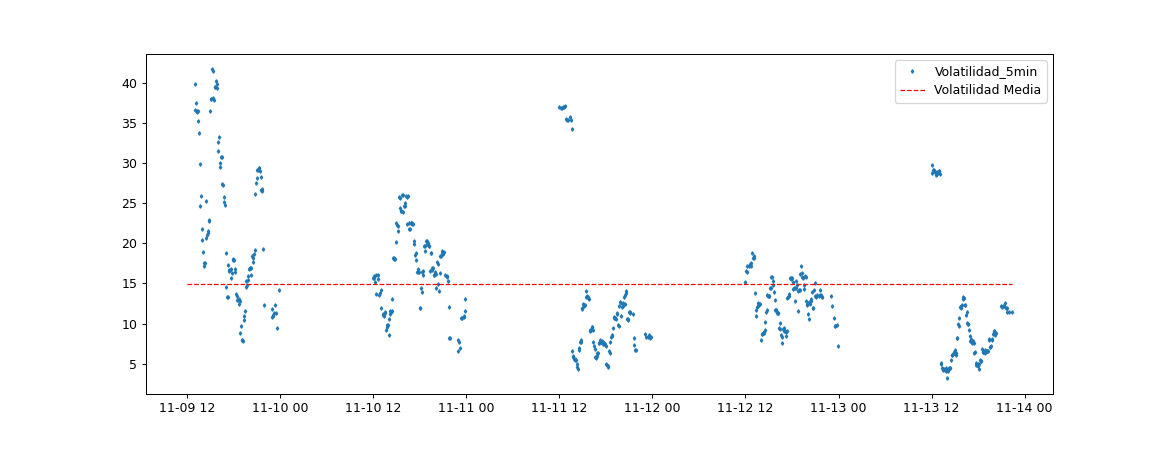

In [75]:
saltos_vol = loaded.loc[loaded.Ticker=='SPY'].pctChange.rolling(12).std() * (12*6.5*250)**0.5
vol_media = saltos_vol.mean()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(saltos_vol, lw=0, markersize=2, marker='d', label='Volatilidad_5min')
ax.plot(saltos_vol.index, [vol_media]*len(saltos_vol), '--r', lw=1, label='Volatilidad Media')
ax.legend()